# Artificial Neural networks as universal function approximators


## Introduction

**Artificial Neural networks** (ANN) are very trendy at the moment, and rightly so. 

They are being used everywhere in big tech companies. For instance, when you use Google translate, or when recommandations appear on your Netflix feed, complex neural networks are being used behind the scene. Behind the success of [Alpha Go](https://en.wikipedia.org/wiki/AlphaGo) at the game of [Go again Lee Sedol](https://www.washingtonpost.com/news/innovations/wp/2016/03/15/what-alphagos-sly-move-says-about-machine-creativity/), an ANN was used to identify the next best move.

ANN are also increasingly being used in Economic modeling, as exemplified by two recent publications:

- [Deep learning for solving dynamic economic models](https://www.sciencedirect.com/science/article/abs/pii/S0304393221000799)
- [Financial Frictions and the Wealth Distribution](https://www.nber.org/system/files/working_papers/w26302/w26302.pdf)

In this blog article, I discuss the reasons behind the popularity of neural networks 

**Spoiler alert:** It has to do with neural network being **universal function approximators.** 

As usual, I like to include Julia code to illustrate how things work in practice. My tool of choice is [Julia](https://julialang.org/) because
it is really fast and it is an increasingly popular programming language. For machine learning tasks, [Flux.jl](https://github.com/FluxML/Flux.jl) is a really good option, so let's use it as well. You can download the code [here](https://github.com/JulienPascal/ANN_Flux).

---

## I. Some theory


### Architecture

If you ended up here, you probably have already some knowledge about what an artificial neural network is. So I will be brief. In a nutshell, a neural network is made of several interconnected layers. Each layer is constituted of nodes. Nodes between adjacent layers exchange information between each others. The way the nodes communicate between each others is captured by parameter values associated to each nodes.

See the graph below:


<img src="ANN.png" alt="Drawing" style="width: 400px;"/>

Source: https://en.wikipedia.org/wiki/Artificial_neural_network#/media/File:Artificial_neural_network.svg


An artificial neural network mimics at a high level what the brain does. The brain is composed of neurons and neurons are connected to each others via synapses. Our brain is very good at recognizing patterns, so one might hope that an artificial network could be a good pattern-recognition machine.

In practice, it is the case. Even better, we have some theorems that tell us that ANN are really, really good.

### Universal approximation theorems

Let me describe two important papers. Below, I reproduce some selected parts of their abstracts:

---

[Hornik Stinchcombe and White (1989)](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208)

"This paper rigorously establishes that **standard multilayer feedforward networks with as few as one hidden layer** using arbitrary squashing functions **are capable of approximating any Borel measurable function from one finite dimensional space to another to any desired degree of accuracy**, provided sufficiently many hidden units are available. In this sense, **multilayer feedforward networks are a class of universal approximators.**"

[Barron (1993)](http://www.stat.yale.edu/~arb4/publications_files/UniversalApproximationBoundsForSuperpositionsOfASigmoidalFunction.pdf) 

"**It  is  shown  that  feedforward networks with one layer of sigmoidal nonlinearities achieve integrated  squared  error  of order  O(1/n),  where  n  is  the  number  of  nodes.**  [...]  For the class of functions  examined  here, the approximation rate  and  the  parsimony  of  the  parameterization  of  the  networks  are 
**surprisingly  advantageous  in high-dimensional settings.**"

---

The paper by **Hornik Stinchcombe and White (1989)** tells us that a very large class of functions can be approximated by a neural network with the architecture we presented above. The underlying function we aim to approximate need only to be "Borel measurable" (from one finite dimensional space to another), which contains pretty much all the useful functions you use in Economics (continuous functions from one finite dimensional space to another are Borel measurable functions).

The paper by **Barron (1993)** tells us that ANN are particularly good approximators when working with many dimensions. 
One way to read this result is that ANN can help to mitigate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). One way to understand the curse of dimensionality is that the number of points needed to approximate a function grows exponentially with the number of dimensions, not linearly. We would like to explain complex phenomenon, with many dimensions and interactions, but traditional approximation methods generally do poorly in such settings. 


Put together, these results tell us that ANN are very good function approximators, even when the number of dimensions is high. 

---
---

## II. Application

Now let's see two applications. To warm up, we will start with a smooth and nice function to approximate.
Then we will move to a more complex function.

### II. A. Easy function

Let's load some useful packages and define the function we would like to approximate

In [1]:
# Dependencies
using Flux
using Plots
using LinearAlgebra
using ProgressMeter
using Statistics
using LaTeXStrings
using Surrogates
gr()

# Define function that we would like to learn with our neural network
f(x) = x[1].^2 + x[2].^2

┌ Warning: Package Surrogates does not have Flux in its dependencies:
│ - If you have Surrogates checked out for development and have
│   added Flux as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Surrogates
│ Loading Flux into Surrogates from project dependency, future warnings for Surrogates are suppressed.
└ @ nothing nothing:888


f (generic function with 1 method)

A function is an infinite-dimensional object. But we need a finite number of values to train our neural network. 
To that, let's create a sample of points from an interval (I use [Sobol sampling](https://en.wikipedia.org/wiki/Sobol_sequence)) and then
evaluate the value of the true function for these points.

In [2]:
n_samples = 100
lower_bound = [-1.0, -1.0]
upper_bound = [1.0, 1.0]

xys = Surrogates.sample(n_samples, lower_bound, upper_bound, SobolSample())
rawInputs = xys
rawOutputs = [[f(xy)] for xy in xys] # Compute outputs for each input
trainingData = zip(rawInputs, rawOutputs);

Now is the fun part of deciding the architecture of our ANN. 
I choose two hidden layers. The number of nodes for the first layer is 
imposed by the dimension of the input (a 2d vector), as well the dimension of 
the final node (a scalar). We still have to choose the number of nodes in between.
For the first hidden layer I choose 784 nodes, and 50 for the second hidden layer.
To be fair, this choices are a bit random (I was a bit influenced by the [Flux.jl tutorial here](https://fluxml.ai/Flux.jl/stable/training/training/)). Feel free to experiment with different values.


In [3]:
# Define the neural network layers (this defines a function called model(x))
# Specify our model
dim_input = 2
dim_ouptut = 1
Q1 = 784;
Q2 = 50;

# Two inputs, one output
model = Chain(Dense(2,Q1,relu),
            Dense(Q1,Q2,relu),
            Dense(Q2,1,identity));

Next we define a **loss function**, which measures the accuracy of the approximation.
The smaller the loss, the better. We use the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) loss function. The name of the game is find the parameter values that minimize the loss function. 
One way to do minimize the loss function is to use the **gradient descent algorithm**.

Here is an intuitive explanation of gradient descent. Imagine that you are on a top of a mountain at that there is a
lot of fog that prevents you from seeing far away. You really want to go down. What should you do? 

One strategy is to look at where you stand and evaluate the direction of the steepest descent in the **neighborhood of your location** (you can't see far away). Then take a step in that direction. Then repeat the process. If the mountain is "well-behaved" (it has no local minima), you will manage to go down the mountain, even though you were just using local information at every step. (Go the very bottom of this blog post to see an illustration of gradient descent on a really easy problem).


In [4]:
# Define loss function and weights 
loss(x, y) = Flux.Losses.mse(model(collect(x)), y)

lr = 0.001 # learning rate

# V1. Gradient descent
opt = Descent(lr)

# V2. ADAM
#decay = 0.9
#momentum =0.999
#opt = ADAM(lr, (decay, momentum))

epochs = 1000 # Define the number of epochs
trainingLosses = zeros(epochs);# Initialize a vector to keep track of the training progress

Next is the most rewarding step: **the training part**. The following block of code
does gradient descent. The function `Flux.train!` uses all the observations
we have in our sample once. Because one iteration is not enough to reach a minimum,
we repeat the process several `epochs`. After each epoch, we calculate the mean squared
error to see how well the model does.

In [5]:
ps = Flux.params(model) #initialize weigths
p = Progress(epochs; desc = "Training in progress"); # Creates a progress bar
showProgress = true

# Training loop
@time for ii in 1:epochs

    Flux.train!(loss, ps, trainingData, opt)

    # Update progress indicator
    if showProgress
        trainingLosses[ii] = mean([loss(x,y) for (x,y) in trainingData])
        next!(p; showvalues = [(:loss, trainingLosses[ii]), (:logloss, log10.(trainingLosses[ii]))], valuecolor = :grey)
    end

end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/reula/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Training in progress100%|███████████████████████████████| Time: 0:01:14
  loss:     0.00015311984653863027
  logloss:  -3.8149685148301593


 74.150485 seconds (98.67 M allocations: 41.134 GiB, 7.78% gc time, 0.60% compilation time)


The next plot shows a surface plot for the original function and the value returned by the ANN (the dots).
Results are quite good. The top right graph displays the value of the loss function as the training takes place.
Gradient descent seems to work well, because the loss function decreases in a nice and monotonic manner. The bottom plots display surface plots for the trained ANN. 

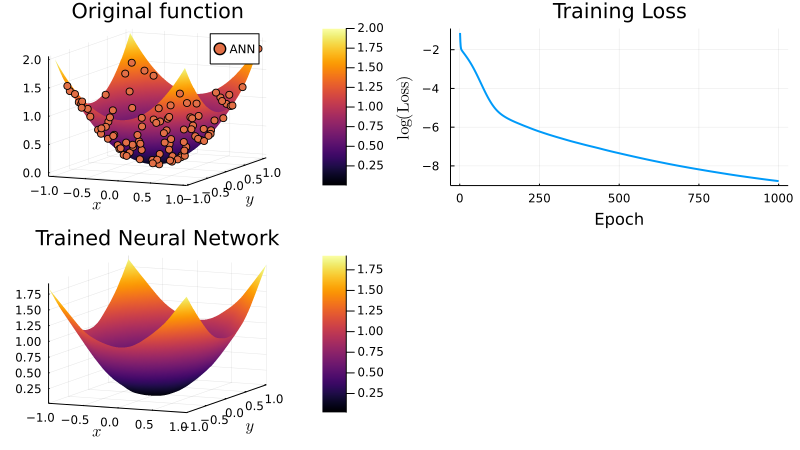

In [6]:
nb_points = 100
grid_x = collect(range(lower_bound[1], upper_bound[1], length= nb_points))
grid_y = collect(range(lower_bound[2], upper_bound[2], length= nb_points))

grid_x_random = [xy[1] for xy in xys]
grid_y_random = [xy[2] for xy in xys]

Zs = [model([x,y])[1] for (x, y) in zip(grid_x_random, grid_y_random)];

# Plot output for trained neural network
p1 = plot(grid_x, grid_y, (x, y) -> f([x,y]), label = "f(x)", st=:surface)
scatter!(p1, grid_x_random, grid_y_random, Zs, label="ANN")
title!("Original function")
xlabel!(L"x")
ylabel!(L"y")


# Plot training loss
p2 = plot(1:epochs, log.(trainingLosses), label = "", linewidth = 2)
title!("Training Loss")
xlabel!("Epoch")
ylabel!(L"\log(\textrm{Loss})")

# Neural network
p3 = plot(grid_x, grid_y, (x, y) -> model([x,y])[1], label = "f(x)", st=:surface)
title!("Trained Neural Network")
xlabel!(L"x")
ylabel!(L"y")

ratio = 9/16
width = 800
pp = plot(p1, p2, p3, size = (width, width*ratio))

### II.B. More challenging function

Ok, so it works for a simple function, which is reassuring. 
Let's now turn to a more challenging function. For instance, 
we can try to approximate the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function), which
is a slightly crazy function often used to test minimization algorithms (it has a global minimum at the origin).

Even with a more complex function, does a great job a approximating the true function, as you can see on the graph below.

In [7]:
function ackley(x; e = exp(1), a = 10.0, b = -0.2, c=2.0*π)
    #a, b, c = 10.0, -0.2, 2.0*π
    len_recip = inv(length(x))
    sum_sqrs = zero(eltype(x))
    sum_cos = sum_sqrs
    for i in x
        sum_cos += cos(c*i)
        sum_sqrs += i^2
    end
    return -a * exp(b * sqrt(len_recip*sum_sqrs)) - exp(len_recip*sum_cos) + a + e
end

n_samples = 1000
lower_bound = [-2.0, -2.0]
upper_bound = [2.0, 2.0]
xys = Surrogates.sample(n_samples, lower_bound, upper_bound, SobolSample())
rawInputs = xys

rawOutputs = [[ackley(xy)] for xy in xys] # Compute outputs for each input
trainingData = zip(rawInputs, rawOutputs);

# Define the neural network layers (this defines a function called model(x))
# Specify our model
Q1 = 784;
Q2 = 50;
Q3 = 10;

# Two inputs, one output
model = Chain(Dense(2,Q1,relu),
            Dense(Q1,Q2,relu),
            Dense(Q2,1,identity));
            
# Define loss function and weights 
loss(x, y) = Flux.Losses.mse(model(collect(x)), y)
ps = Flux.params(model)

# Train the neural network 
epochs = 1000
showProgress = true
lr = 0.001 # learning rate

# V1. Gradient descent
opt = Descent(lr)

# V2. ADAM
#decay = 0.9
#momentum =0.999
#opt = ADAM(lr, (decay, momentum))

trainingLosses = zeros(epochs) # Initialize vectors to keep track of training
p = Progress(epochs; desc = "Training in progress") # Creates a progress bar

@time for ii in 1:epochs

    Flux.train!(loss, ps, trainingData, opt)

    # Update progress indicator
    if showProgress
        trainingLosses[ii] = mean([loss(x,y) for (x,y) in trainingData])
        next!(p; showvalues = [(:loss, trainingLosses[ii]), (:logloss, log10.(trainingLosses[ii]))], valuecolor = :grey)
    end

end



┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/reula/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Training in progress100%|███████████████████████████████| Time: 0:11:03
  loss:     0.0192186958507131
  logloss:  -1.716276086181283


663.936816 seconds (404.63 M allocations: 378.345 GiB, 10.16% gc time, 0.02% compilation time)


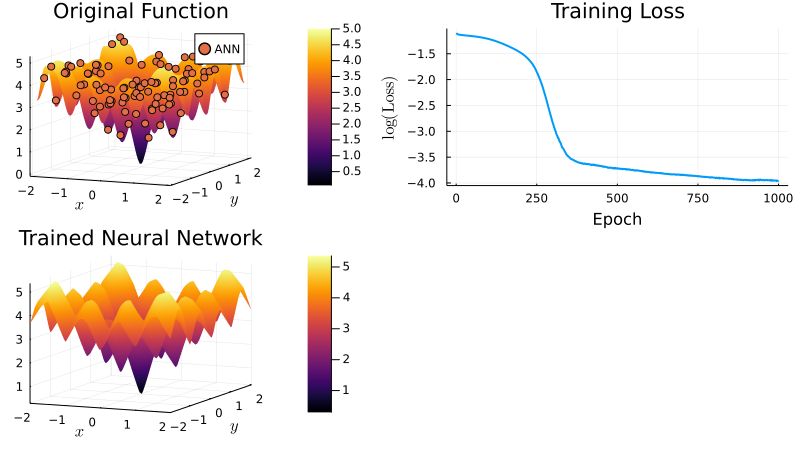

In [8]:
nb_points = 100
grid_x = collect(range(lower_bound[1], upper_bound[1], length= nb_points))
grid_y = collect(range(lower_bound[2], upper_bound[2], length= nb_points))

grid_x_random = [xy[1] for xy in xys]
grid_y_random = [xy[2] for xy in xys]

Zs = [model([x,y])[1] for (x, y) in zip(grid_x_random, grid_y_random)];

# Plot output for trained neural network
p1 = plot(grid_x, grid_y, (x, y) -> ackley([x,y]), label = "f(x)", st=:surface)
# Show somes points, not all of them (otherwise hard to see anything)
scatter!(p1, grid_x_random[1:100], grid_y_random[1:100], Zs[1:100], label="ANN")
title!("Original Function")
xlabel!(L"x")
ylabel!(L"y")


# Plot training loss
p2 = plot(1:epochs, log.(trainingLosses), label = "", linewidth = 2)
title!("Training Loss")
xlabel!("Epoch")
ylabel!(L"\log(\textrm{Loss})")


# Plot output for trained neural network
p3 = plot(grid_x, grid_y, (x, y) -> model([x,y])[1], label = "f(x)", st=:surface)
title!("Trained Neural Network")
xlabel!(L"x")
ylabel!(L"y")

ratio = 9/16
width = 800
pp = plot(p1, p2, p3, size = (width, width*ratio))

---

## Conclusion


Artificial Neural Network are universal function approximators. This blog post showed how to start using ANN to approximate relatively simple functions. 

When trying to solve an economic model, one often has to find an unknown function that satisfies a number of 
restrictions. In a subsequent post, I wish to describe how an ANN can be used to find such an unknown function.

---
---

### Extra: gradient descent visually

Below is an illustration of gradient descent.
We want to find the minimum of the function `J(x)=x^2` and we start 
at the point `-20`. 

The algorithm proceeds iteratively:
1. Calculate the **gradient** at the current value. This gives us the direction 
of the maximum change for the function `J`.
2. Because we are looking for a **minimum** and not a maximum, take a step in the opposite
direction of the maximum change
3. Repeat steps 1-2

In [12]:
import Pkg; Pkg.add("GradDescent")
using GradDescent
#Code from here: https://jacobcvt12.github.io/GradDescent.jl/stable/
#I made only slight modifications to the original code

# objective function and gradient of objective function
J(x) = x^2
dJ(x) = 2*x

# number of epochs
epochs = 150

# instantiation of Adagrad optimizer with learning rate of 2
opt = Adagrad(η=2.0)

# initial value for x (usually initialized with a random value)
x = -20.0 #initial position on the function
values_x = zeros(epochs) #initialization
value_y = zeros(epochs) #initialization
iter_x = zeros(epochs) #initialization

for i in 1:epochs
    # Save values for plotting
    values_x[i] = x
    value_y[i] = J(x)
    iter_x[i] = i
    
    # calculate the gradient wrt to the current x
    g = dJ(x)

    # change to the current x
    δ = update(opt, g)
    x -= δ
end


LoadError: Unsatisfiable requirements detected for package [38;5;11mDistributions [31c24e10][39m:
 [38;5;11mDistributions [31c24e10][39m log:
 ├─possible versions are: [38;5;11m0.16.0-0.25.34[39m or uninstalled
 ├─restricted by compatibility requirements with [38;5;14mSymbolics [0c5d862f][39m to versions: [38;5;11m0.23.0-0.25.34[39m
 │ └─[38;5;14mSymbolics [0c5d862f][39m log:
 │   ├─possible versions are: [38;5;14m0.1.0-4.1.1[39m or uninstalled
 │   └─restricted to versions [38;5;14m*[39m by an explicit requirement, leaving only versions [38;5;14m0.1.0-4.1.1[39m
 ├─restricted by compatibility requirements with [38;5;6mGradDescent [e1397348][39m to versions: [38;5;11m0.16.0-0.23.12[39m, leaving only versions: [38;5;11m0.23.0-0.23.12[39m
 │ └─[38;5;6mGradDescent [e1397348][39m log:
 │   ├─possible versions are: [38;5;6m0.3.1[39m or uninstalled
 │   └─restricted to versions [38;5;6m*[39m by an explicit requirement, leaving only versions [38;5;6m0.3.1[39m
 └─restricted by compatibility requirements with [38;5;3mFillArrays [1a297f60][39m to versions: [38;5;11m[0.16.0-0.21.9, 0.24.11-0.25.34][39m or uninstalled — no versions left
   └─[38;5;3mFillArrays [1a297f60][39m log:
     ├─possible versions are: [38;5;3m0.2.0-0.12.7[39m or uninstalled
     ├─restricted by compatibility requirements with [38;5;11mBandedMatrices [aae01518][39m to versions: [38;5;3m[0.2.0-0.8.14, 0.9.1-0.12.7][39m
     │ └─[38;5;11mBandedMatrices [aae01518][39m log:
     │   ├─possible versions are: [38;5;11m0.5.1-0.16.11[39m or uninstalled
     │   └─restricted to versions [38;5;11m*[39m by an explicit requirement, leaving only versions [38;5;11m0.5.1-0.16.11[39m
     └─restricted by compatibility requirements with [38;5;14mGridapMakie [41f30b06][39m to versions: [38;5;3m0.11.0-0.12.7[39m
       └─[38;5;14mGridapMakie [41f30b06][39m log:
         ├─possible versions are: [38;5;14m0.1.0-0.1.1[39m or uninstalled
         └─restricted to versions [38;5;14m*[39m by an explicit requirement, leaving only versions [38;5;14m0.1.0-0.1.1[39m

As you can see on the plot below, we start from the left hand side and then we make some quite big moves
to the right. As time passes, the points go from yellow to darker colors. 
After about 150 iterations, we are very close to the true minimum at 0.

In [10]:
plot(values_x, value_y, label="J(x)")
scatter!(values_x, value_y, marker_z = iter_x, color = cgrad(:thermal, rev = true), label="Position", colorbar_title="Iteration")
xlabel!(L"x")
ylabel!(L"J(x)")

LoadError: UndefVarError: values_x not defined

In [11]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
